# EDA 

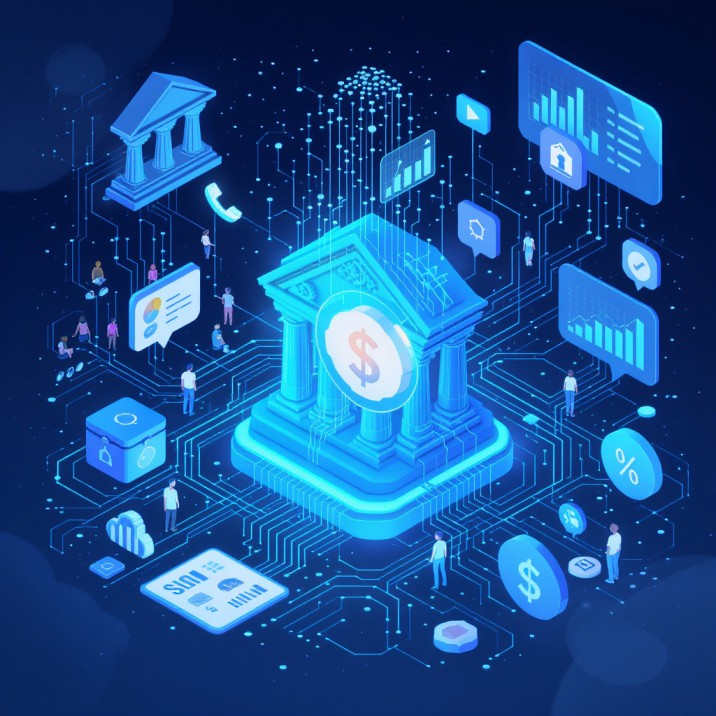

### When Numbers Speak Louder Than Words... ✨


> Imagine a bank calling you on a regular afternoon, asking if you’d like to invest your savings in a term deposit. Some people say yes, some say no. But what if the secret of who says yes was already hidden in the data?

This dataset is not just about clients and calls  it’s about patterns of human behavior, financial decisions, and the subtle art of persuasion. Each row is like a story and a decision that could change someone’s financial future.

In this notebook, we will dive into those stories, uncover hidden patterns, and transform raw data into insights. The journey begins with Exploratory Data Analysis (EDA) where visuals speak louder than tables. From there, we’ll craft meaningful features, build models that can learn from human behavior, and test how well they can predict the ultimate yes or no.

The goal is not only to score well but also to understand:

* What drives people to accept or refuse?

* Which factors truly influence decisions?

* How can we make sense of the models we build?

 >If you enjoy this journey into the intersection of data, behavior, and decision-making, don’t forget **to leave an upvote ⭐**  it keeps the motivation alive and helps more people discover this story hidden in the numbers.

## Dataset Description (features)

**age →** Age of the client (in years).

**balance →** Average yearly account balance (in euros).

**day →** Last contact day of the month (numeric).

**duration →** Duration of the last contact (in seconds).

**campaign →** Number of contacts performed during this campaign for this client.

**pdays →** Number of days since the client was last contacted from a previous campaign (-1 means client was not previously contacted).

**previous →** Number of contacts performed before this campaign.

**job →** Type of job .

**marital →** Marital status .

**education →** Education level .

**default →** Whether the client has credit in default (yes, no).

**housing →** Whether the client has a housing loan (yes, no).

**loan →** Whether the client has a personal loan (yes, no).

**contact →** Type of communication contact .

**month →** Last contact month of the year .

**poutcome →** Outcome of the previous marketing campaign.

**y →** Target variable (binary): whether the client subscribed to a term deposit (yes = 1, no = 0).

## Import Libraries

In [1]:
# -------------------------
# Basic / Environment
# -------------------------
import os                          # file paths, env vars
import sys                         # system utilities
import gc                          # garbage collection (memory mgmt)
import random                      # reproducible sampling
import warnings                    # suppress harmless warnings
from datetime import datetime      # timestamps / parsing

# make outputs deterministic where possible
SEED = 42
random.seed(SEED)

# suppress warnings for cleaner notebook output
warnings.filterwarnings("ignore")


# -------------------------
# Data handling
# -------------------------
import numpy as np                 # numerical arrays & math
import pandas as pd                # dataframes / CSV I/O
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)


# -------------------------
# Visualization (static + interactive)
# -------------------------
import matplotlib.pyplot as plt    # base plotting
import seaborn as sns              # statistical visualisations
# interactive (very useful on Kaggle to engage readers)
import plotly.express as px
import plotly.graph_objects as go

# -------------------------
# Statistical tests & utilities
# -------------------------
from scipy import stats            # KS test, chi2, distributions
from collections import Counter    # quick counts / diagnostics
from scipy.stats import fisher_exact
import statsmodels.api as sm
import statsmodels.formula.api as smf

# -------------------------
# Preprocessing & encoding
# -------------------------
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
import category_encoders as ce     # target / ordinal / count encoders


# -------------------------
# Modeling (lightweight for EDA: quick baselines / lift charts)
# -------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# model evaluation helpers
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    log_loss,
    brier_score_loss,
)


# -------------------------
# Explainability & feature importance (mini-models for EDA)
# -------------------------
import shap                        # SHAP values for feature importance


# -------------------------
# I/O, parallelism & progress
# -------------------------
from tqdm.auto import tqdm         # progress bars
import joblib                      # caching intermediate artifacts


# -------------------------
# Kaggle-specific / polishing
# -------------------------
from IPython.display import display, HTML   # nicer tables / html in notebook



# -------------------------
# Plot styling helper
# -------------------------
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


## Load Data

In [2]:
TRAIN_FILE = "/kaggle/input/playground-series-s5e8/train.csv"
TEST_FILE  = "/kaggle/input/playground-series-s5e8/test.csv"

train = pd.read_csv(TRAIN_FILE, index_col="id", low_memory=False)
test  = pd.read_csv(TEST_FILE,  index_col="id", low_memory=False)

print("Datasets loaded successfully ✅")
print(f"Train shape: {train.shape}")
print(f"Test shape:  {test.shape}")


Datasets loaded successfully ✅
Train shape: (750000, 17)
Test shape:  (250000, 16)


In [3]:
print("🔹 First 5 rows:")
display(train.head())



🔹 First 5 rows:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [4]:
rows, cols = train.shape
mem_mb = train.memory_usage(deep=True).sum() / 1024**2
print(f"📊 Overview — Train Data")
print(f"Shape: {rows} rows × {cols} cols    |    Memory: {mem_mb:.2f} MB")
train.info()


📊 Overview — Train Data
Shape: 750000 rows × 17 cols    |    Memory: 453.57 MB
<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int64 
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int64 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int64 
 10  month      750000 non-null  object
 11  duration   750000 non-null  int64 
 12  campaign   750000 non-null  int64 
 13  pdays      750000 non-null  int64 
 14  previous   750000 non-null  int64 
 15  poutcome   750000 non-null  object
 16  y          750000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 103.0+ MB


In [5]:
miss = train.isna().sum()
miss = miss[miss > 0].sort_values(ascending=False)
if len(miss):
    print("🔹 Missing values (sorted):")
    print(miss)
else:
    print("🔹 Missing values: None")


🔹 Missing values: None


### No missing values 😃!
This dataset was clearly built with care either through rigorous data collection or solid preprocessing. And that’s great news for us: no need to wrestle with missing values.

Because let’s be honest: handling them is never simple. There’s no universal method, and a wrong choice can seriously hurt model quality.

In [6]:
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train.select_dtypes(include=['object','category','bool']).columns.tolist()

print(f"🔹 Numerical columns ({len(num_cols)}): {num_cols}\n")
print(f"🔹 Categorical/other columns ({len(cat_cols)}): {cat_cols}\n")


🔹 Numerical columns (8): ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']

🔹 Categorical/other columns (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']



In [7]:
if num_cols:
    print("🔹 Descriptive statistics (numerical):")
    display(train[num_cols].describe().T)


🔹 Descriptive statistics (numerical):


,count,mean,std,min,25%,50%,75%,max
age,750000.0,40.926395,10.098829,18.0,33.0,39.0,48.0,95.0
balance,750000.0,1204.067397,2836.096759,-8019.0,0.0,634.0,1390.0,99717.0
day,750000.0,16.117209,8.250832,1.0,9.0,17.0,21.0,31.0
duration,750000.0,256.229144,272.555662,1.0,91.0,133.0,361.0,4918.0
campaign,750000.0,2.577008,2.718514,1.0,1.0,2.0,3.0,63.0
pdays,750000.0,22.412733,77.319998,-1.0,-1.0,-1.0,-1.0,871.0
previous,750000.0,0.298545,1.335926,0.0,0.0,0.0,0.0,200.0
y,750000.0,0.120651,0.325721,0.0,0.0,0.0,0.0,1.0


### some key insights
* Balances are highly skewed: many clients at 0 but some extreme outliers up to €99k (and even negatives!).
* Call durations vary a lot  some conversations last just a second, others go on for * more than an hour.
* Campaign contacts are usually low (median = 2), but a few clients were contacted over 60 times (!).
* For pdays, most values are -1 meaning no prior contact a strong signal to consider.

In [8]:
top_n_cat = 8
if cat_cols:
    print(f"🔹 Top {top_n_cat} categories (sample) for categorical columns:")
    for c in cat_cols:
        print(f"  -> {c} (nunique={train[c].nunique()}):")
        print(train[c].value_counts(dropna=False).head(top_n_cat).to_string())
        print("-" * 40)


🔹 Top 8 categories (sample) for categorical columns:
  -> job (nunique=12):
job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
----------------------------------------
  -> marital (nunique=3):
marital
married     480759
single      194834
divorced     74407
----------------------------------------
  -> education (nunique=4):
education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
----------------------------------------
  -> default (nunique=2):
default
no     737151
yes     12849
----------------------------------------
  -> housing (nunique=2):
housing
yes    411288
no     338712
----------------------------------------
  -> loan (nunique=2):
loan
no     645023
yes    104977
----------------------------------------
  -> contact (nunique=3):
contact
cellular     486655
unknown      231627
telephone     31718

### 📌 Key insights from categorical features:
* Most clients work in management, blue-collar, or technician jobs, while smaller groups include retirees and self-employed.
* Very few clients are in default (~1.7%), so this variable might have low predictive power.
* The campaign is concentrated in a few months (especially May, August, and July).
* The outcome of previous campaigns is overwhelmingly unknown, with only a small fraction marked as success or failure.

## Target Analysis

Target Variable Distribution:



,Counts,Percentage (%)
y,,
0,659512,87.93
1,90488,12.07


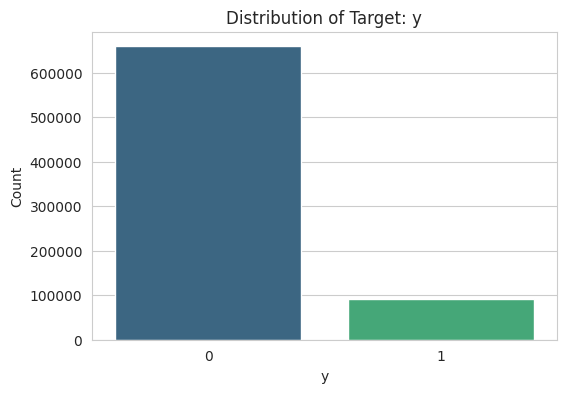

In [9]:
# Target Analysis
def analyze_target(df, target="y"):
    """
    Analyze the target variable distribution.
    Shows counts, percentages, and a simple barplot.
    """
    print("Target Variable Distribution:\n")
    counts = df[target].value_counts()
    percentages = df[target].value_counts(normalize=True) * 100
    
    display(pd.DataFrame({"Counts": counts, "Percentage (%)": percentages.round(2)}))
    
    # Barplot
    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index, y=counts.values, palette="viridis")
    plt.title(f"Distribution of Target: {target}")
    plt.xlabel(target)
    plt.ylabel("Count")
    plt.show()

# Run for training data
analyze_target(train, target="y")



**⚠️ Imbalanced data alert**: Only ~12% of clients said yes. A naïve model could simply predict "no" and still appear accurate  which makes resampling strategies crucial. Also, be careful with evaluation metrics: **AUC may not reflect true performance** in this scenario, so choose metrics that properly capture your model’s ability to detect the minority class.

## Numerical Variables Analysis


=== age ===


,age
n,750000.000000
n_unique,78.000000
mean,40.926395
median,39.000000
std,10.098829
skew,0.586137
kurtosis,-0.069561


  → point-biserial r = 0.0095, p = 1.62e-16


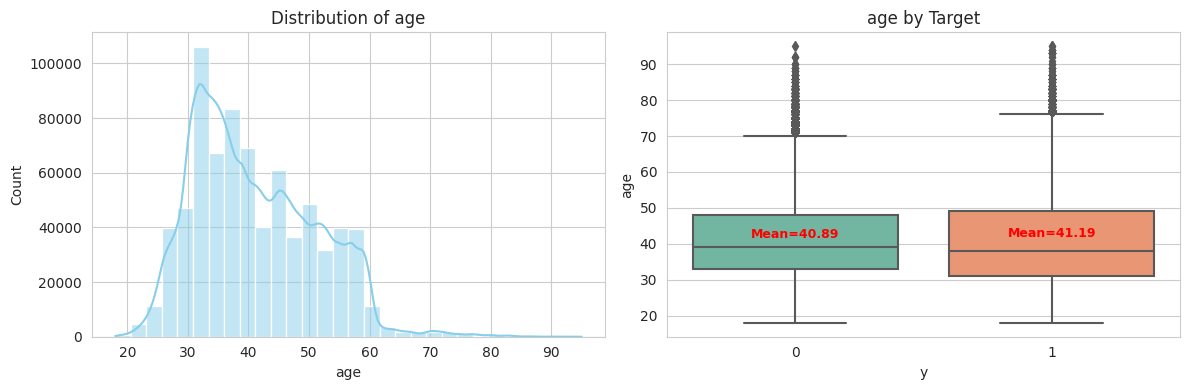


=== balance ===


,balance
n,750000.000000
n_unique,8217.000000
mean,1204.067397
median,634.000000
std,2836.096759
skew,12.304123
kurtosis,268.863623


  → point-biserial r = 0.1225, p = 0
  ⚠ Skew=12.30 → consider log1p or rank transform.


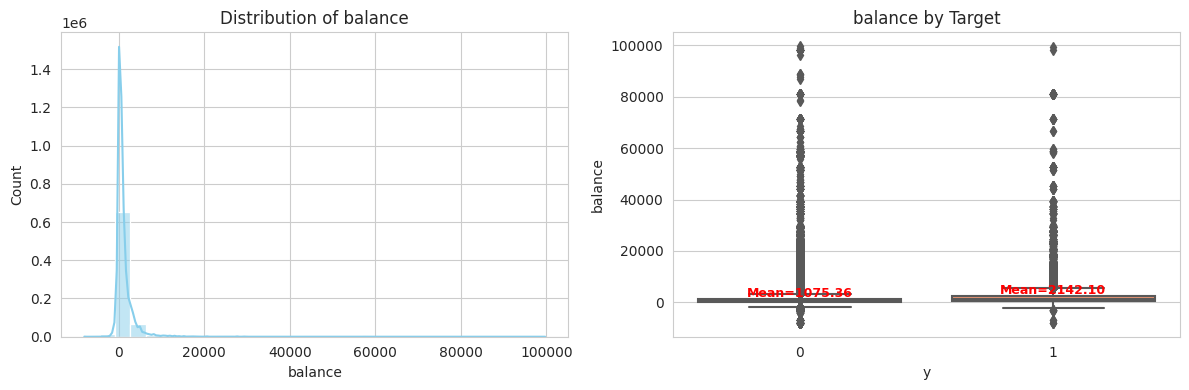


=== day ===


,day
n,750000.000000
n_unique,31.000000
mean,16.117209
median,17.000000
std,8.250832
skew,0.054014
kurtosis,-1.044458


  → point-biserial r = -0.0496, p = 0


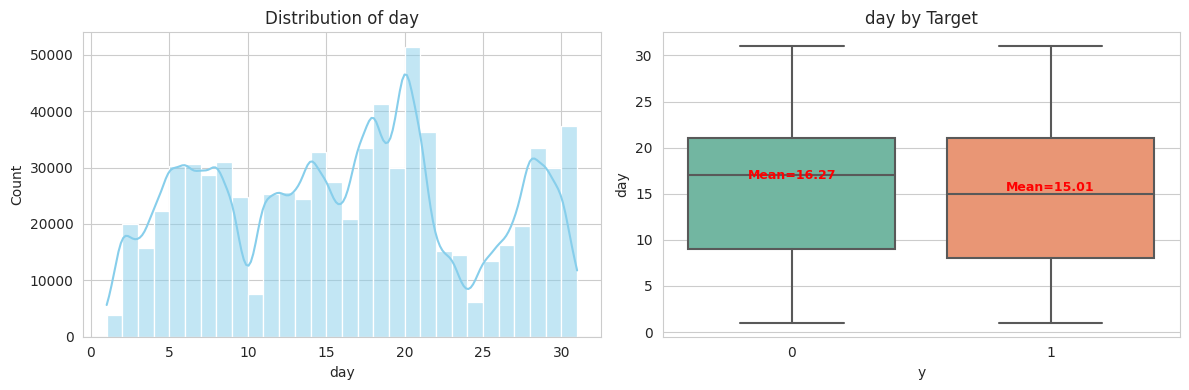


=== duration ===


,duration
n,750000.000000
n_unique,1760.000000
mean,256.229144
median,133.000000
std,272.555662
skew,2.048776
kurtosis,6.434523


  → point-biserial r = 0.5193, p = 0
  ⚠ Skew=2.05 → consider log1p or rank transform.


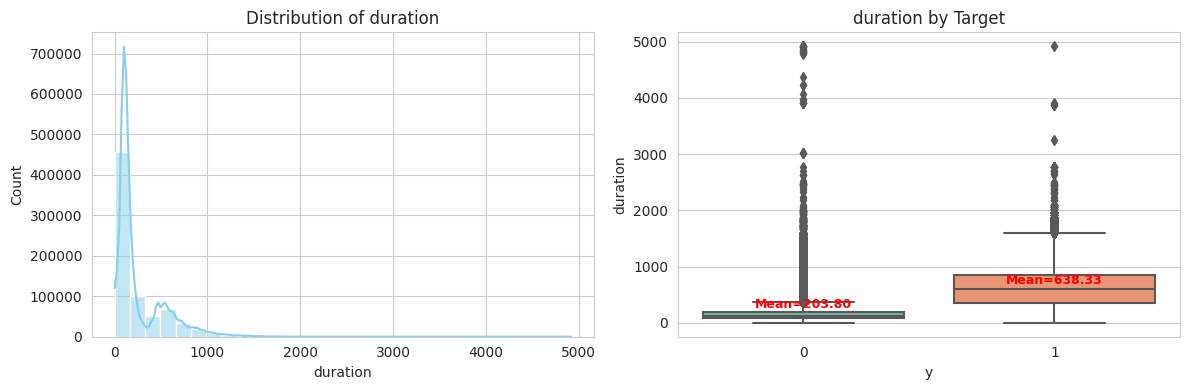


=== campaign ===


,campaign
n,750000.000000
n_unique,52.000000
mean,2.577008
median,2.000000
std,2.718514
skew,4.810437
kurtosis,37.493557


  → point-biserial r = -0.0758, p = 0
  ⚠ Skew=4.81 → consider log1p or rank transform.


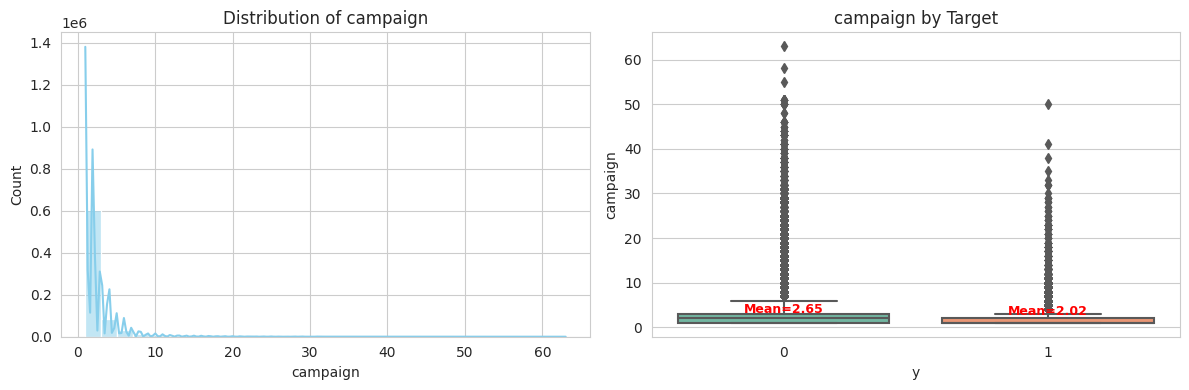


=== pdays ===


,pdays
n,750000.000000
n_unique,596.000000
mean,22.412733
median,-1.000000
std,77.319998
skew,3.625049
kurtosis,13.597849


  → point-biserial r = 0.0893, p = 0
  ⚠ Skew=3.63 → consider log1p or rank transform.


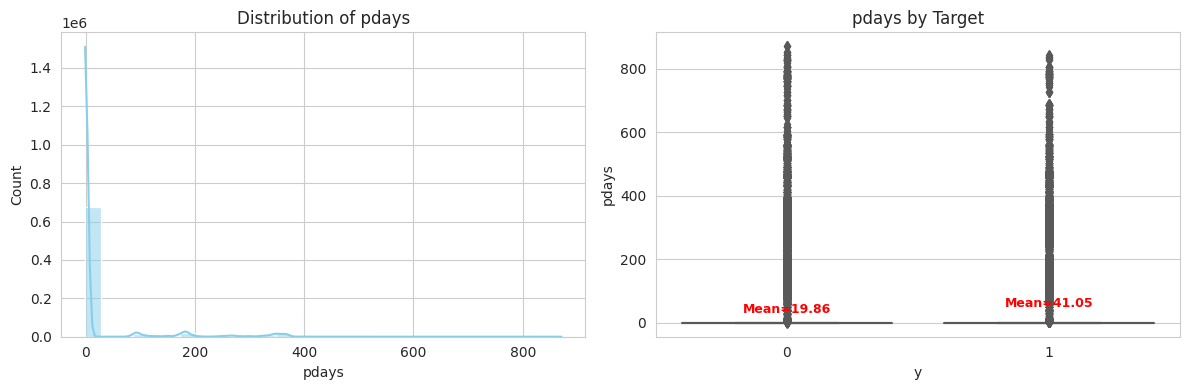


=== previous ===


,previous
n,750000.000000
n_unique,50.000000
mean,0.298545
median,0.000000
std,1.335926
skew,13.749885
kurtosis,820.304755


  → point-biserial r = 0.1196, p = 0
  ⚠ Skew=13.75 → consider log1p or rank transform.


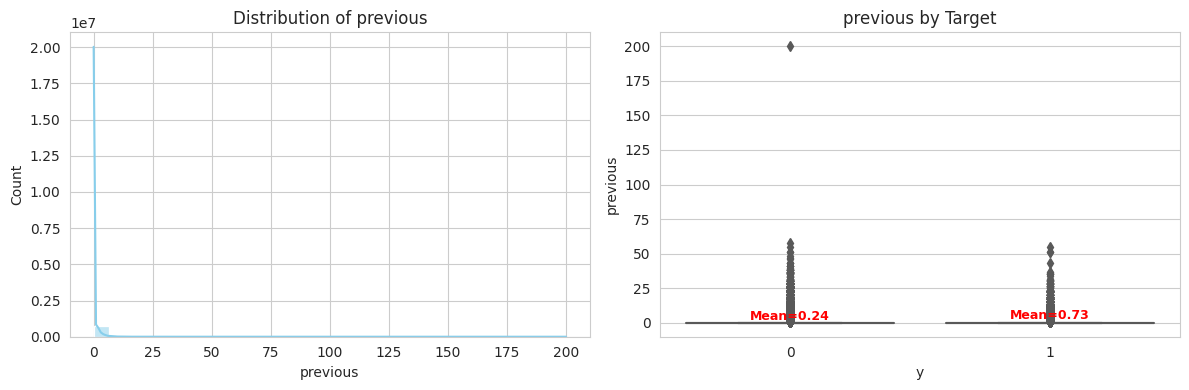

In [10]:
def univariate_numeric(df, numeric_cols, target=None, sample_frac=1.0, plot=True):
    if sample_frac <= 0 or sample_frac > 1:
        raise ValueError("sample_frac must be in (0, 1].")
    plot_df = df.sample(frac=sample_frac, random_state=SEED) if sample_frac < 1.0 else df
    
    for col in numeric_cols:
        if col not in df.columns:
            print(f"\n⚠️  Column '{col}' not found — skip.")
            continue
        
        print(f"\n=== {col} ===")
        s = df[col]
        
        # Essential stats
        mean, median, std = s.mean(), s.median(), s.std()
        skew, kurtosis = s.skew(), s.kurtosis()
        n, nunique = len(s), s.nunique()
        
        # Compact summary
        stats_table = {
            "n": n, "n_unique": nunique,
            "mean": mean, "median": median,
            "std": std, "skew": skew, "kurtosis": kurtosis,
        }
        display(pd.DataFrame.from_dict(stats_table, orient="index", columns=[col]))
        
        # Correlation with target (if binary and provided)
        if target is not None and target in df.columns:
            joined = df[[col, target]].dropna()
            if joined.shape[0] >= 5 and set(joined[target].unique()).issubset({0,1}):
                r, p = stats.pointbiserialr(joined[target], joined[col])
                print(f"  → point-biserial r = {r:.4f}, p = {p:.3g}")
        
        # Skewness note
        if abs(skew) > 1:
            print(f"  ⚠ Skew={skew:.2f} → consider log1p or rank transform.")
        
        # Plots
        if plot:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            
            # Distribution
            sns.histplot(plot_df[col].dropna(), bins=30, kde=True, ax=axes[0], color="skyblue")
            axes[0].set_title(f"Distribution of {col}")
            
            # Boxplot by target 
            if target is not None and target in df.columns:
                sns.boxplot(x=plot_df[target].astype(str), y=plot_df[col], ax=axes[1], palette="Set2")
                axes[1].set_title(f"{col} by Target")
                axes[1].set_xlabel(target)

                # ➡️ Ajouter les moyennes par classe
                means = plot_df.groupby(target)[col].mean()
                for i, cls in enumerate(means.index):
                    axes[1].text(i, means[cls], f"Mean={means[cls]:.2f}", 
                                 ha='center', va='bottom', fontsize=9, color="red", fontweight="bold")
            else:
                sns.boxplot(x=plot_df[col].dropna(), ax=axes[1], color="lightgreen")
                axes[1].set_title(f"Boxplot of {col}")
            
            plt.tight_layout()
            plt.show()

numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'] 
univariate_numeric(train, numeric_cols, target="y")


### 🔎 Class comparison 

* Balance: subscribers hold on average ~2× higher balances than non-subscribers. Strong signal but with a skewed distribution and valid outliers.

* Duration: biggest signal → successful calls last ~3× longer on average.

* Pdays: mean ≈ 41 (Yes) vs 19 (No) → recency of previous contact matters.

* Previous: mean 0.73 (Yes) vs 0.24 (No) → prior interactions increase conversion likelihood.

> ✨ Takeaway: From my analysis, balance, call duration, pdays, and previous appear to be the strongest predictors. In contrast, age, day, and campaign seem less impactful. I’ll need to handle skewness and outliers carefully, while giving extra attention to duration and past contact variables during feature engineering.

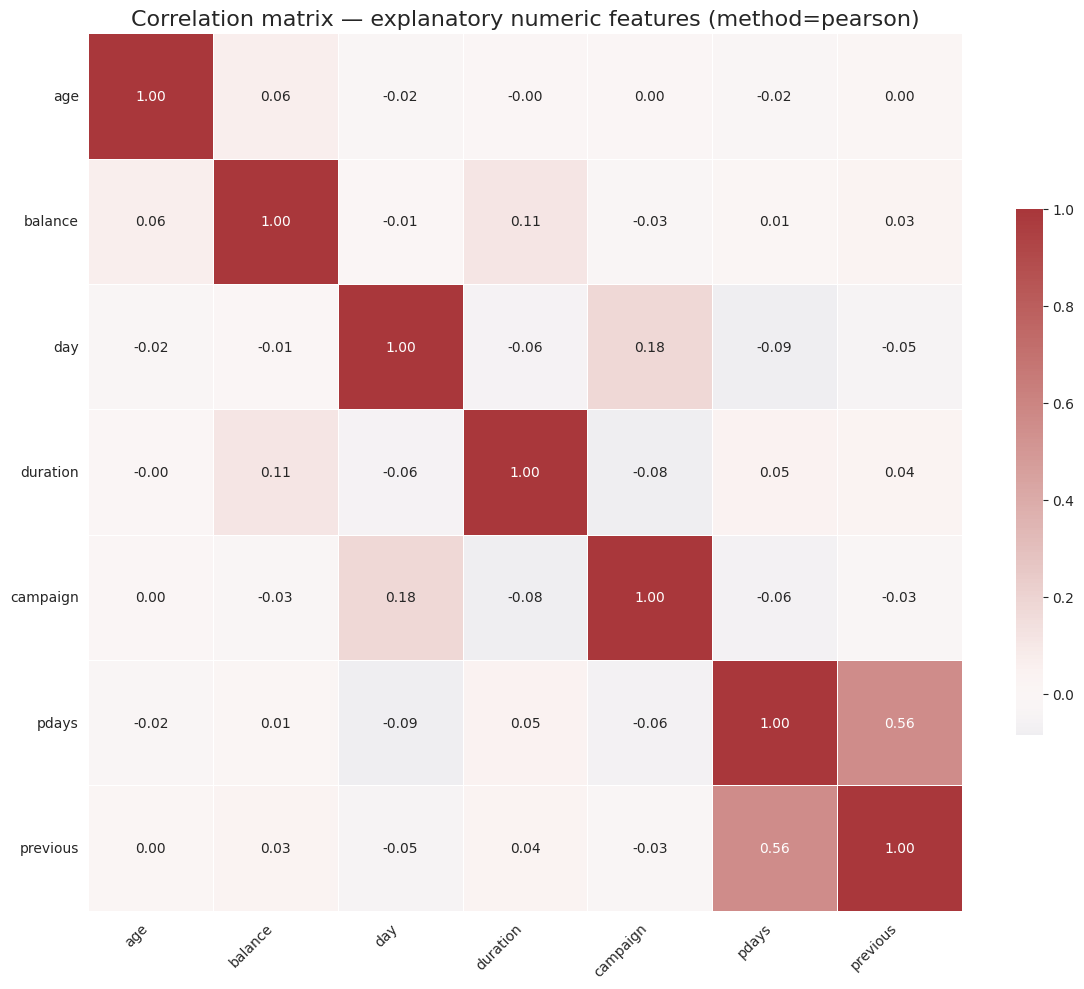

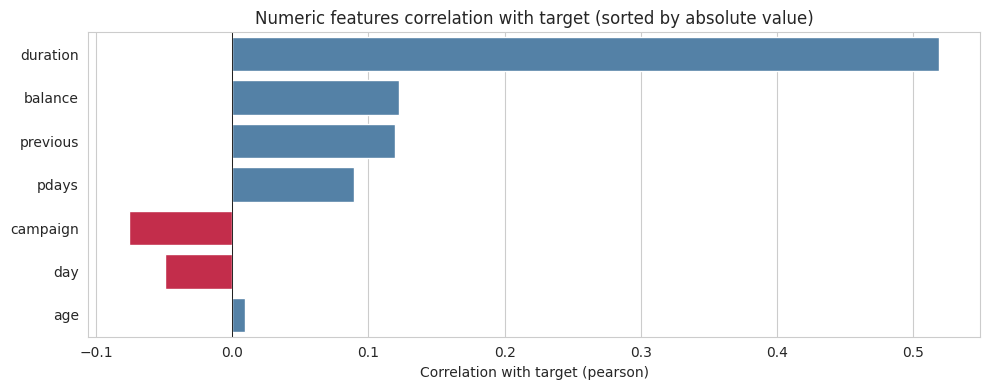

In [11]:

def plot_numeric_correlation_matrix(df, target="y", method="pearson", annotate=True, cmap="vlag"):
    
    # 2) Select numeric columns and separate features vs target
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target not in num_cols:
        raise ValueError(f"Target '{target}' is not in the numeric columns list.")
    feature_cols = [c for c in num_cols if c != target]
    if len(feature_cols) == 0:
        raise ValueError("No numeric explanatory features found (all numeric cols are only the target).")
    
    # 3) Compute correlation matrix for explanatory features only
    corr_features = df[feature_cols].corr(method=method)
    
    # -------- Full Heatmap for explanatory variables (no mask) --------
    # Dynamically choose a large figure size based on number of features
    n = len(feature_cols)
    # width/height scaling factors - adjust to taste
    width = max(12, 0.45 * n)
    height = max(10, 0.45 * n)
    
    fig, ax = plt.subplots(figsize=(width, height))
    
    # Annotate only when not too many features (to avoid clutter)
    annotate_cells = annotate and (n <= 20)
    
    sns.heatmap(
        corr_features,
        cmap=cmap,
        center=0,
        annot=annotate_cells,
        fmt=".2f" if annotate_cells else "",
        linewidths=0.5,
        cbar_kws={"shrink": 0.6},
        ax=ax,
        square=False
    )
    ax.set_title(f"Correlation matrix — explanatory numeric features (method={method})", fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # -------- Correlation with target (barplot) --------
    corr_with_target = df[num_cols].corr(method=method)[target].drop(target)
    corr_with_target = corr_with_target.sort_values(key=lambda x: x.abs(), ascending=False)
    
    plt.figure(figsize=(10, max(4, 0.4*len(corr_with_target))))
    colors = ["crimson" if v < 0 else "steelblue" for v in corr_with_target.values]
    sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette=colors)
    plt.xlabel(f"Correlation with target ({method})")
    plt.title("Numeric features correlation with target (sorted by absolute value)", fontsize=12)
    plt.axvline(0, color="k", linewidth=0.6)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_numeric_correlation_matrix(train, target="y", method="pearson", annotate=True)


### Correlation snapshot

1. Most numeric features barely move the needle with the target. The one real standout is duration, showing a solid +0.50 correlation — clearly a feature to watch.
2. Between predictors, correlations are mild overall, with just pdays and previous pairing up at ~0.56.

👉 Bottom line: no major multicollinearity issues, but pdays/previous deserve a closer look.

## Categorical Variables Analysis


=== Feature: job ===


,job,count,positives,pct
0,management,175541,26400,15.04
1,blue-collar,170498,11498,6.74
2,technician,138107,16341,11.83
3,admin.,81492,9490,11.65
4,services,64209,5311,8.27
5,retired,35185,8664,24.62
6,self-employed,19020,2462,12.94
7,entrepreneur,17718,1442,8.14
8,unemployed,17634,3171,17.98
9,housemaid,15912,1347,8.47


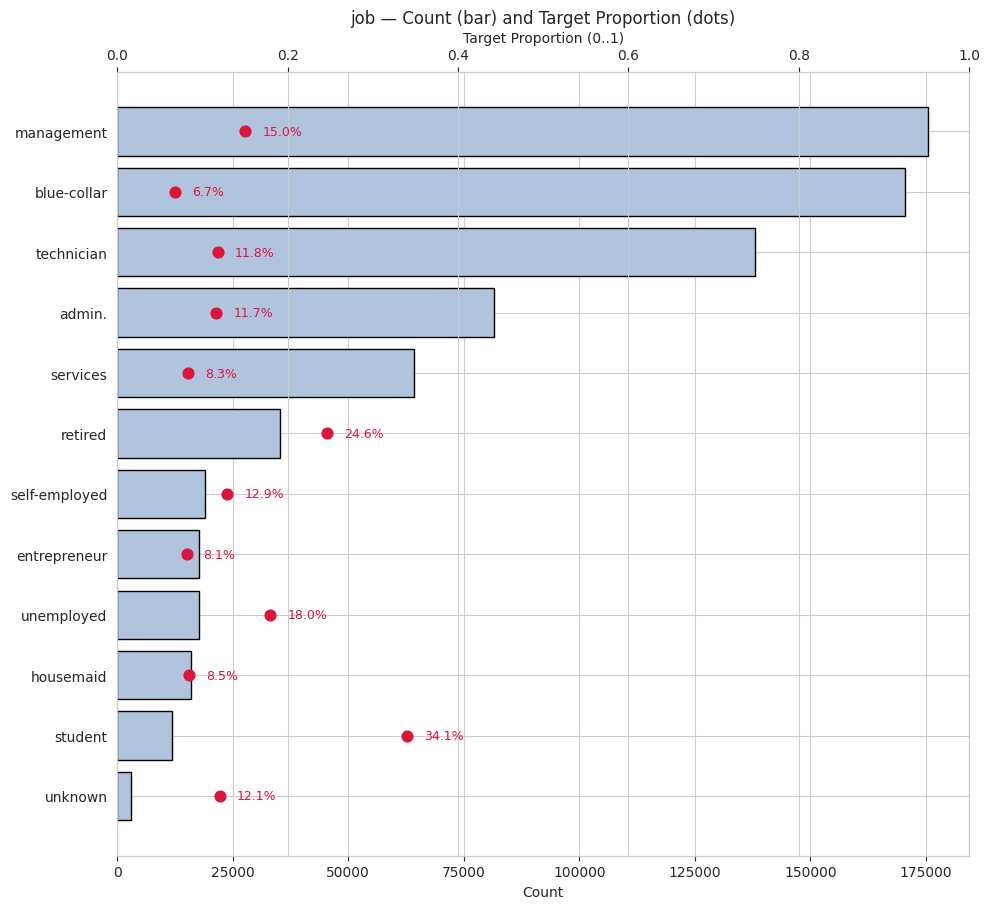


=== Feature: marital ===


,marital,count,positives,pct
0,married,480759,48976,10.19
1,single,194834,33210,17.05
2,divorced,74407,8302,11.16


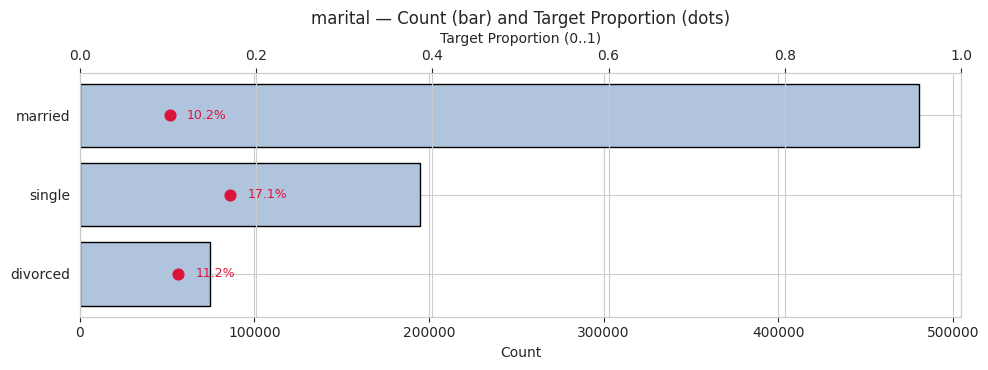


=== Feature: education ===


,education,count,positives,pct
0,secondary,401683,42374,10.55
1,tertiary,227508,37004,16.26
2,primary,99510,8269,8.31
3,unknown,21299,2841,13.34


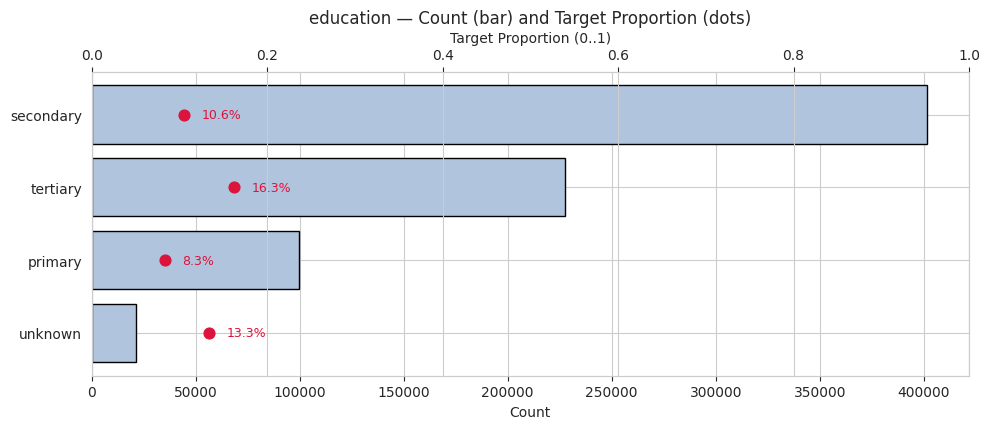


=== Feature: default ===


,default,count,positives,pct
0,no,737151,89893,12.19
1,yes,12849,595,4.63


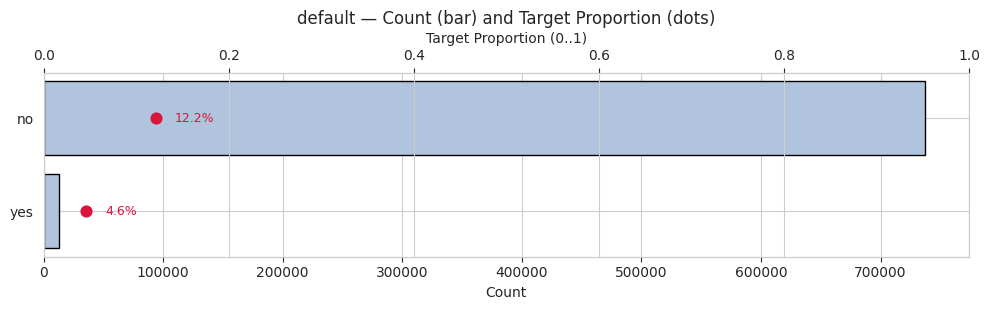


=== Feature: housing ===


,housing,count,positives,pct
0,yes,411288,30950,7.53
1,no,338712,59538,17.58


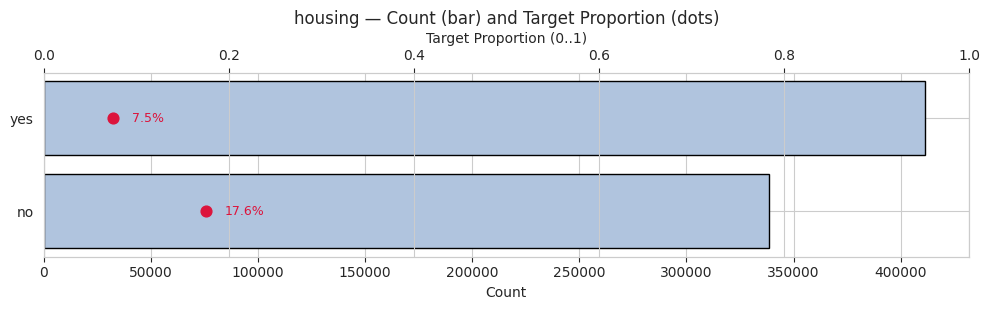


=== Feature: loan ===


,loan,count,positives,pct
0,no,645023,84742,13.14
1,yes,104977,5746,5.47


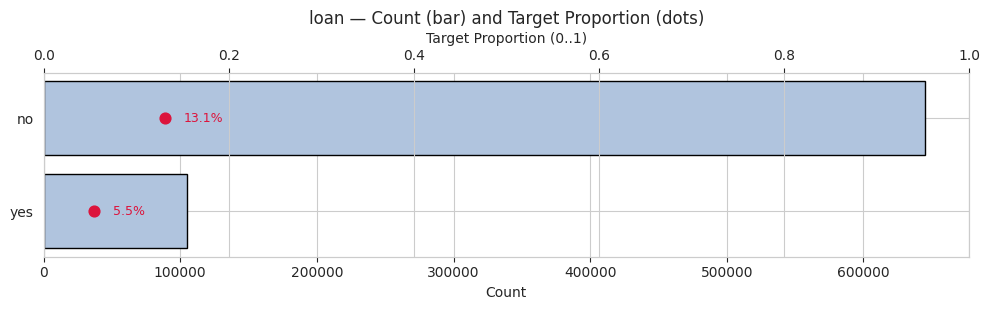


=== Feature: contact ===


,contact,count,positives,pct
0,cellular,486655,76200,15.66
1,unknown,231627,9949,4.30
2,telephone,31718,4339,13.68


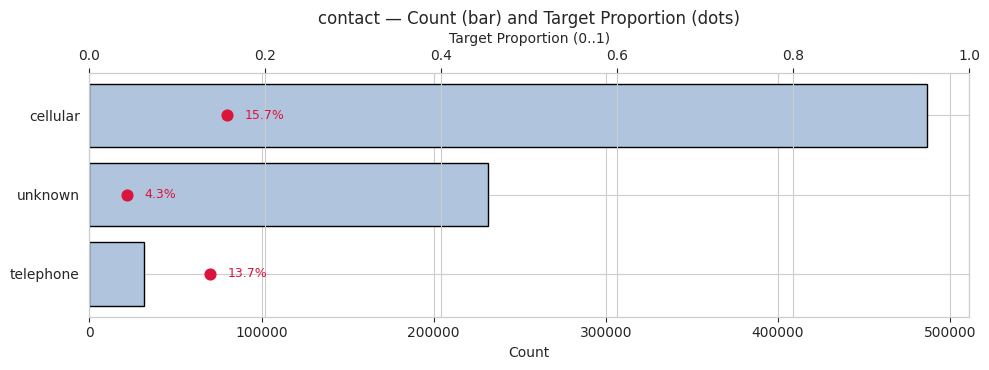


=== Feature: month ===


,month,count,positives,pct
0,may,228411,16298,7.14
1,aug,128859,14453,11.22
2,jul,110647,10052,9.08
3,jun,93670,9716,10.37
4,nov,66062,7254,10.98
5,apr,41319,9737,23.57
6,feb,37611,7778,20.68
7,jan,18937,2351,12.41
8,oct,9204,4510,49.00
9,sep,7409,3962,53.48


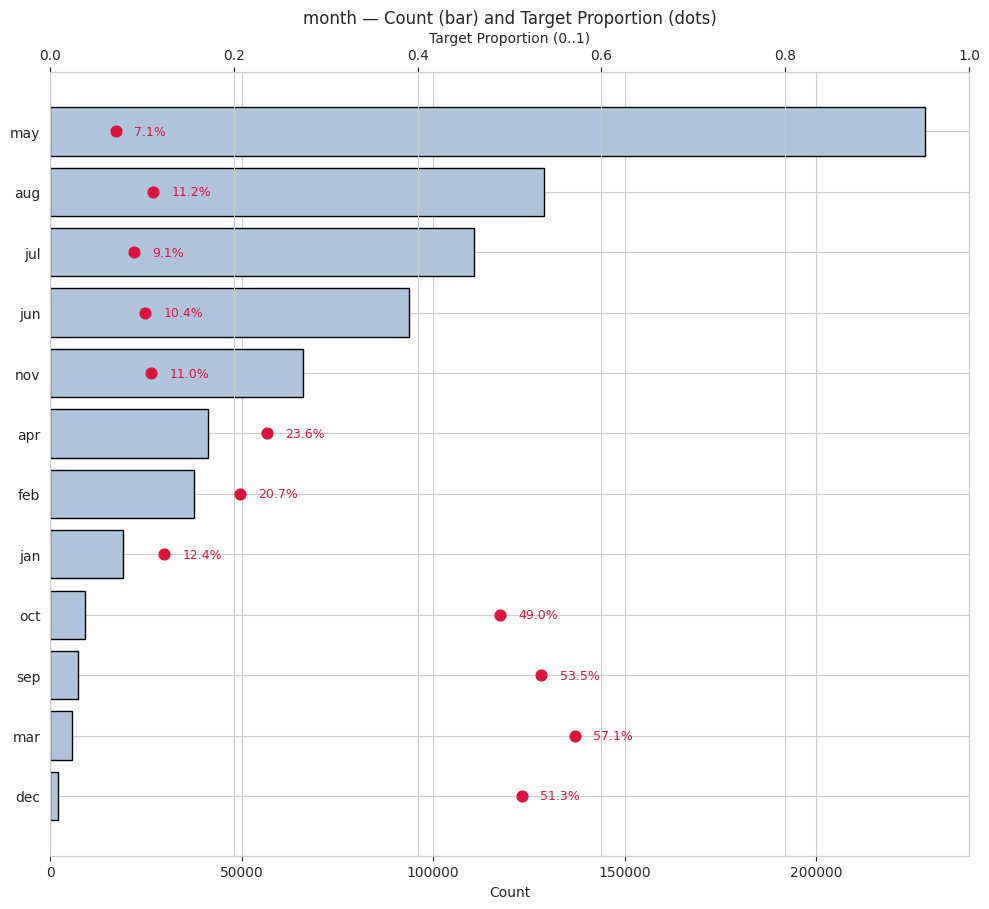


=== Feature: poutcome ===


,poutcome,count,positives,pct
0,unknown,672450,68521,10.19
1,failure,45115,5991,13.28
2,success,17691,13516,76.40
3,other,14744,2460,16.68


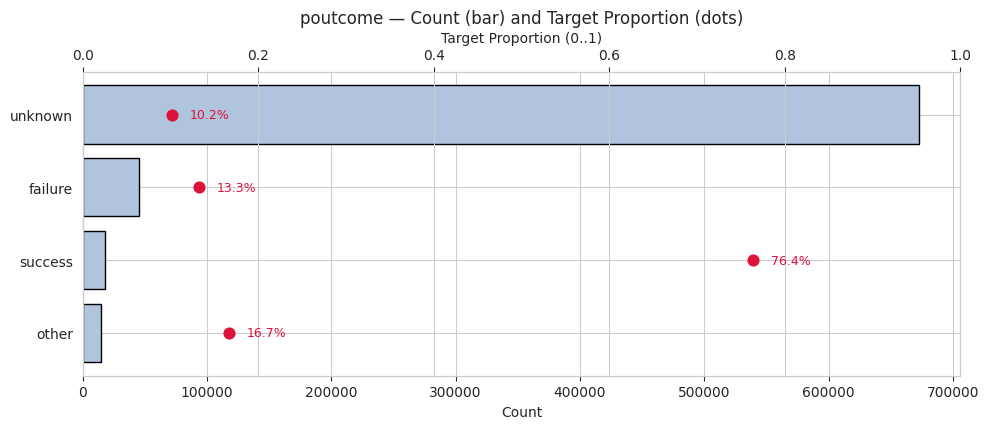

In [12]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
def analyze_categorical_features_improved_no_ci(df, target="y", max_unique=20, top_n=20, sort_by="count"):

    # detect categorical-like columns
    categorical_features = [
        col for col in df.columns 
        if (df[col].dtype == "object" or df[col].nunique() <= max_unique) and col != target
    ]
    
    for col in categorical_features:
        print(f"\n=== Feature: {col} ===")
        
        # aggregated summary: counts, sum (positives), mean
        grp = df.groupby(col)[target].agg(count='count', positives='sum', mean='mean').reset_index()
        grp['pct'] = (grp['mean'] * 100).round(2)
        
        # select top_n based on requested criterion
        if sort_by == "target":
            top = grp.sort_values('mean', ascending=False).head(top_n)
        else:
            top = grp.sort_values('count', ascending=False).head(top_n)
        
        # Display table (sorted by count)
        display_cols = ['count', 'positives', 'pct']
        display(top[[col] + display_cols].sort_values('count', ascending=False).reset_index(drop=True))
        
        # Plot: horizontal bar for counts + dot for target proportion (no CI)
        top = top.reset_index(drop=True)
        y_pos = np.arange(len(top))
        
        fig, ax_count = plt.subplots(figsize=(10, 0.6 * len(top) + 2))
        
        # Horizontal bars = counts
        ax_count.barh(y_pos, top['count'], align='center', color='lightsteelblue', edgecolor='k')
        ax_count.set_yticks(y_pos)
        ax_count.set_yticklabels(top[col].astype(str))
        ax_count.invert_yaxis()
        ax_count.set_xlabel("Count")
        ax_count.set_title(f"{col} — Count (bar) and Target Proportion (dots)")
        
        # Secondary axis for target proportion (0..1)
        ax_prop = ax_count.twiny()
        ax_prop.set_xlim(0, 1)  # proportion scale 0..1
        # plot dots (no errorbars)
        ax_prop.scatter(top['mean'], y_pos, color='crimson', s=60, zorder=5)
        ax_prop.set_xlabel("Target Proportion (0..1)")
        
        # annotate proportion pct next to each dot
        for i, (m, p) in enumerate(zip(top['mean'], top['pct'])):
            ax_prop.text(m + 0.02, i, f"{p:.1f}%", va='center', color='crimson', fontsize=9)
        
        plt.tight_layout()
        plt.show()

# Example usage:
analyze_categorical_features_improved_no_ci(train, target="y", max_unique=30, top_n=12, sort_by='count')


### 🎯 Headlines 

* Poutcome = success → 76.4%. This is a nuclear signal: if the previous campaign was a success, conversion now is massive.

* Months (Mar/Sep/Oct/Dec/Apr/Feb) show unusually high conversion (Mar 57%, Sep 53%, Oct 49%, Dec 51%, Apr 23.6%, Feb 20.7%) — strong seasonality or campaign timing effect.

* Students & Retirees stand out: students 34%, retired 24.6%  two very different life stages, same high receptivity.

* Housing = no converts much more (17.6%) than housing = yes (7.5%) surprising and actionable.

* Loan = yes is a negative signal: borrowers convert far less (~5.5%) ; A non-borrowers (~13%).

* Tertiary education and single status show above-average conversion (~16% and ~17% respectively).

* Default = yes is rare and converts poorly (4.6%) — low frequency, low conversion.

## Advanced Analysis 

In [13]:
# 1) Cramér's V for categorical features vs binary target
def cramers_v_for_categoricals(df, categorical_cols, target="y"):
    results = []
    n = len(df)
    for col in categorical_cols:
        ct = pd.crosstab(df[col], df[target])
        chi2, p, dof, ex = stats.chi2_contingency(ct)
        phi2 = chi2 / n
        r, k = ct.shape
        V = np.sqrt(phi2 / min(k-1, r-1)) if min(k-1, r-1) > 0 else 0.0
        results.append({"feature": col, "cramers_v": V, "chi2_p": p})
    res = pd.DataFrame(results).sort_values("cramers_v", ascending=False).reset_index(drop=True)
    return res


# 2) Interaction heatmap using log-odds 
def interaction_logodds_heatmap(df, row_col, col_col, target="y", min_count=50, cmap="RdBu_r"):
  
    pivot = df.groupby([row_col, col_col])[target].agg(sum='sum', count='count').reset_index()
    pivot['p'] = pivot['sum'] / pivot['count']
    pivot.loc[pivot['count'] < min_count, 'p'] = np.nan
    eps = 1e-6
    pivot['p_clamped'] = pivot['p'].clip(eps, 1-eps)
    pivot['logodds'] = np.log(pivot['p_clamped'] / (1 - pivot['p_clamped']))
    heat = pivot.pivot(index=row_col, columns=col_col, values='logodds')
    # plot
    plt.figure(figsize=(14, max(6, 0.35 * heat.shape[0])))
    sns.heatmap(heat, cmap=cmap, center=0, linewidths=.5, annot=False)
    plt.title(f"Log-odds heatmap: {row_col} × {col_col} (min_count={min_count})")
    plt.ylabel(row_col)
    plt.xlabel(col_col)
    plt.tight_layout()
    plt.show()
    return heat



# 3) Top segments discovery (combinations with high uplift and volume)
def top_segments(df, group_cols, target='y', top_k=20, min_count=100):
    
    baseline = df[target].mean()
    grp = df.groupby(group_cols)[target].agg(count='count', positives='sum').reset_index()
    grp['rate'] = grp['positives'] / grp['count']
    grp = grp[grp['count'] >= min_count].copy()
    grp['uplift'] = grp['rate'] - baseline
    return grp.sort_values(['uplift', 'count'], ascending=[False, False]).head(top_k)


# 6) Fit a compact logistic regression with one interaction (example)
def fit_logistic_interaction(df, formula, sample_frac=1.0):
   
    if sample_frac < 1.0:
        df_fit = df.sample(frac=sample_frac, random_state=1)
    else:
        df_fit = df
    model = smf.logit(formula=formula, data=df_fit).fit(disp=False, maxiter=200)
    params = model.params
    conf = model.conf_int()
    or_df = pd.DataFrame({
        "coef": params,
        "odds_ratio": np.exp(params),
        "ci_lower": np.exp(conf[0]),
        "ci_upper": np.exp(conf[1])
    })
    return model, or_df.sort_values("odds_ratio", key=lambda x: x.abs(), ascending=False)


In [14]:
# Define lists
categorical_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']
numeric_cols = ['age','duration','balance','day','campaign','pdays','previous']  # adapt as needed

# 1) Cramér's V (categorical associations)
cramers = cramers_v_for_categoricals(train, categorical_cols, target='y')
display(cramers.head(9))



,feature,cramers_v,chi2_p
0,poutcome,0.308990,0.000000e+00
1,month,0.264025,0.000000e+00
2,contact,0.159913,0.000000e+00
3,job,0.157306,0.000000e+00
4,housing,0.153585,0.000000e+00
5,marital,0.090998,0.000000e+00
6,education,0.089501,0.000000e+00
7,loan,0.081633,0.000000e+00
8,default,0.030118,5.685409e-150


### Key points
**What is Cramér’s V?
Cramér’s V is a measure of association between two categorical variables (ranges from 0 to 1). It tells you the strength of the relationship (not just whether it exists). Rough guide: ~0.1 = small, ~0.3 = moderate, ~0.5 = strong. Unlike p-values, Cramér’s V gives a sense of practical importance.**

*  Top signals: poutcome (0.31) and month (0.26) — moderate, important predictors.

*  Moderate signals: contact, job, housing (~0.15).

*  Weak signals: marital, education, loan (~0.08–0.09).

*  Negligible: default (~0.03) despite tiny p-values (large sample size).

  **Caveats: p-values ≈ 0 due to big N — focus on effect sizes. poutcome may introduce leakage; test models with/without it.**


### heatmap using log-odds
This heatmap shows how two categorical variables interact to influence subscription.
We first estimate the probability of a “yes,” then convert it into log-odds:

* Positive values = stronger propensity to subscribe

* Negative values = weaker propensity

Cells with very few samples are filtered out to reduce noise.

Ultimately, this visualization serves as a strategic map: it highlights segments, seasons, or profiles where the effect is amplified  offering concrete leads for feature creation, refined targeting, and better model design.

> **I generated multiple heatmaps, but I decided to keep only those involving the most impactful variables and providing genuinely meaningful insights.**

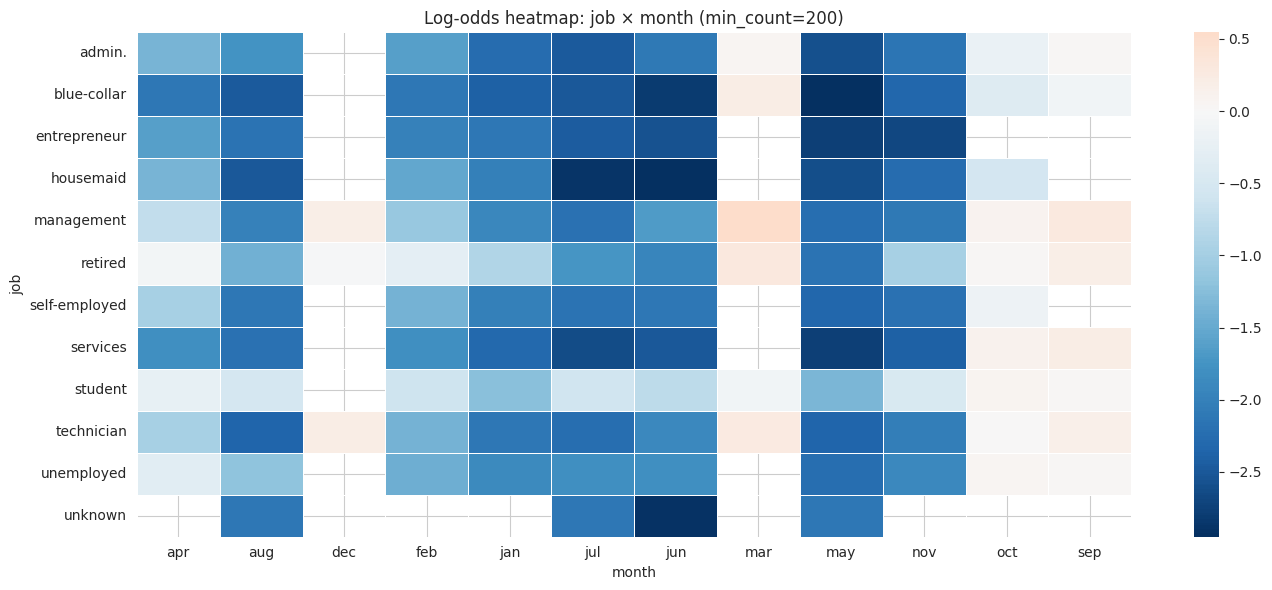

In [15]:
#Interaction heatmap job x month
heat0 = interaction_logodds_heatmap(train, 'job', 'month', target='y', min_count=200)


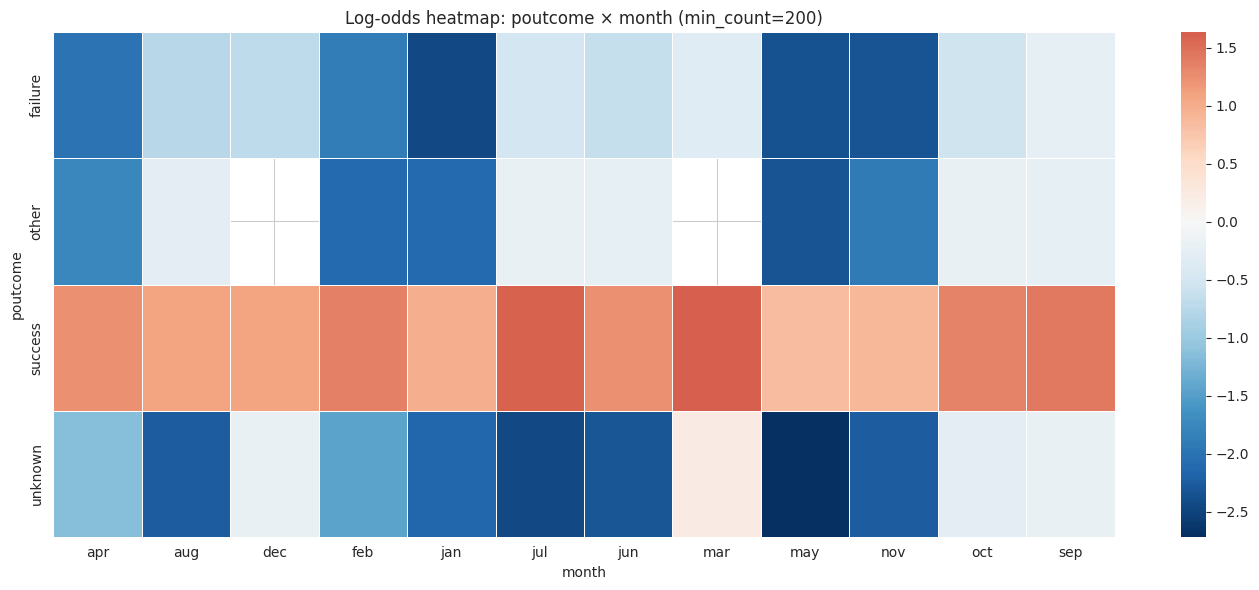

In [16]:
heat1 = interaction_logodds_heatmap(train, 'poutcome', 'month', target='y', min_count=200)


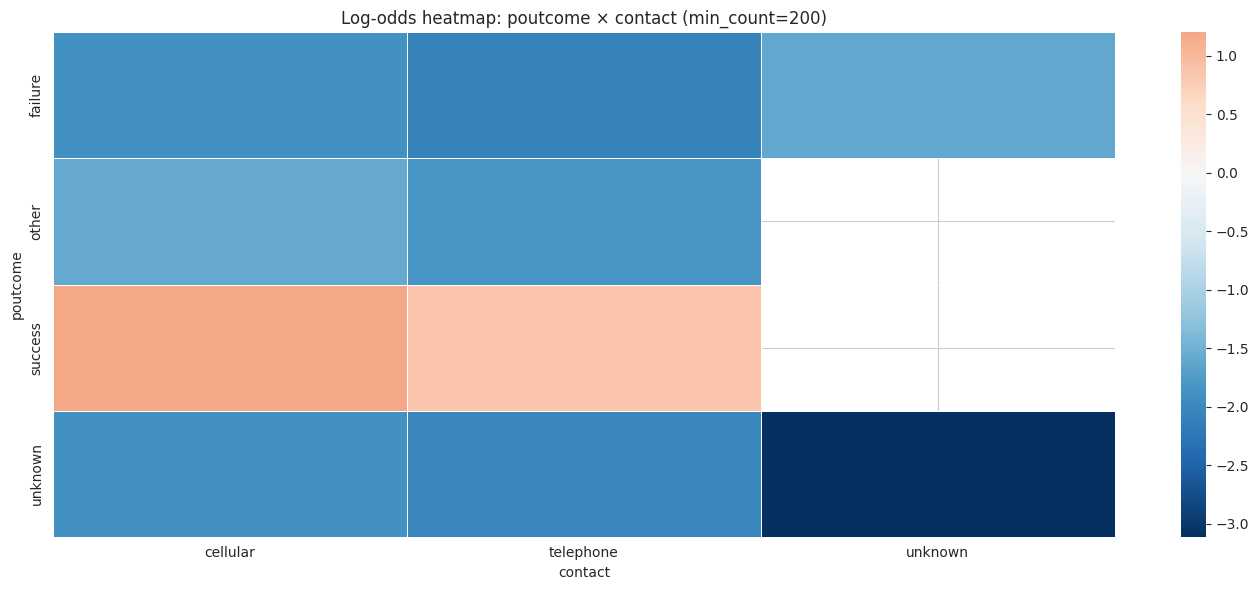

In [17]:
heat2 = interaction_logodds_heatmap(train, 'poutcome', 'contact', target='y', min_count=200)


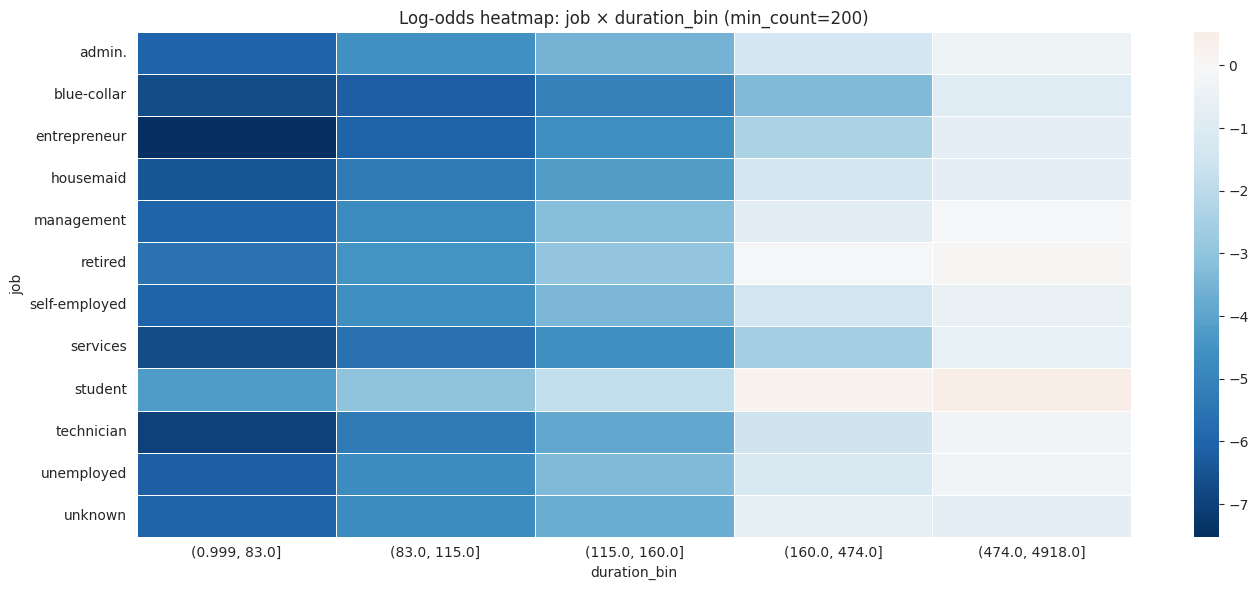

In [18]:
# Créer des classes de duration (ex: 5 intervalles par quantiles)
train['duration_bin'] = pd.qcut(train['duration'], q=5, duplicates="drop")

# Puis refaire ton heatmap
heat3 = interaction_logodds_heatmap(train, 'job', 'duration_bin', target='y', min_count=200)


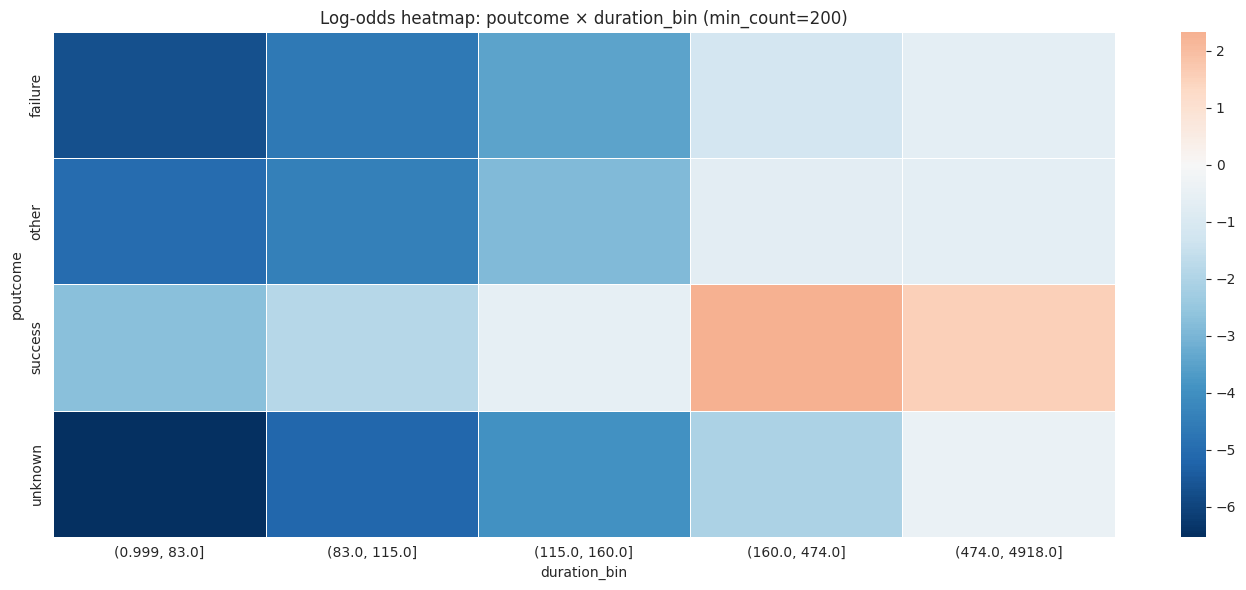

In [19]:
heat4 = interaction_logodds_heatmap(train, 'poutcome', 'duration_bin', target='y', min_count=200)


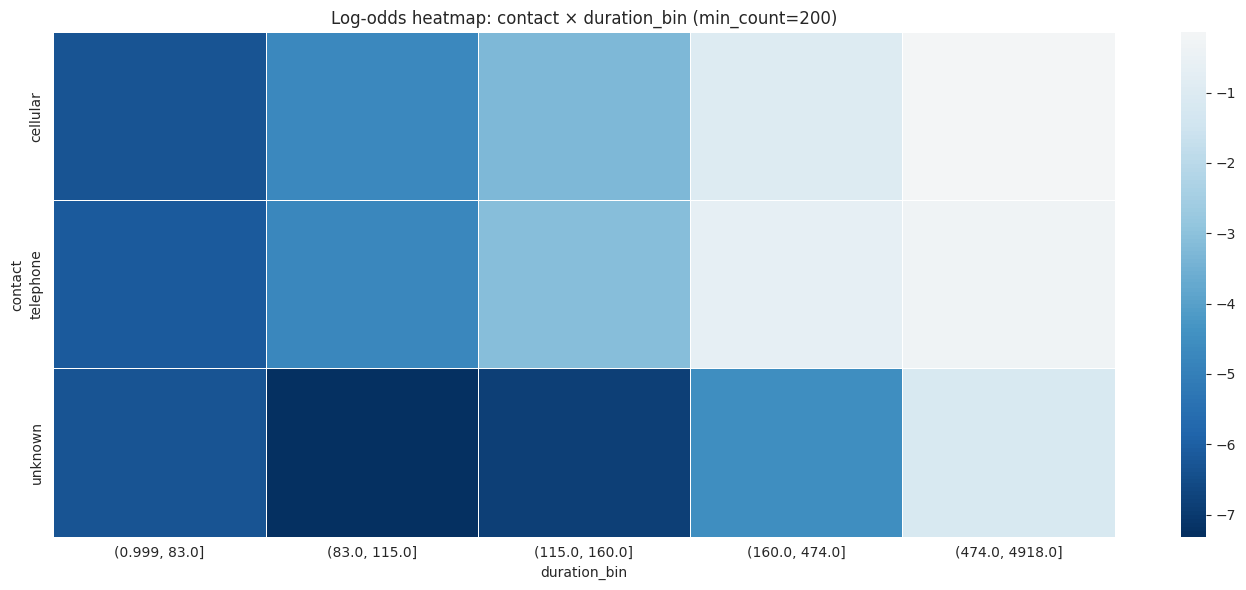

In [20]:
heat5 = interaction_logodds_heatmap(train, 'contact', 'duration_bin', target='y', min_count=200)


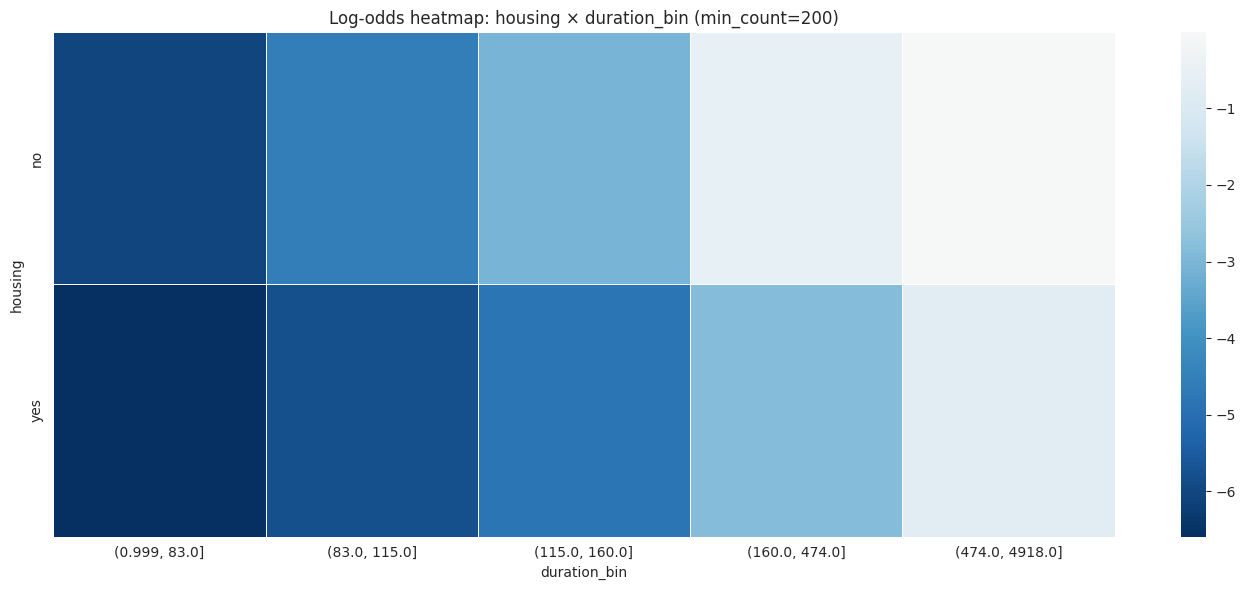

In [21]:

heat6 = interaction_logodds_heatmap(train, 'housing', 'duration_bin', target='y', min_count=200)


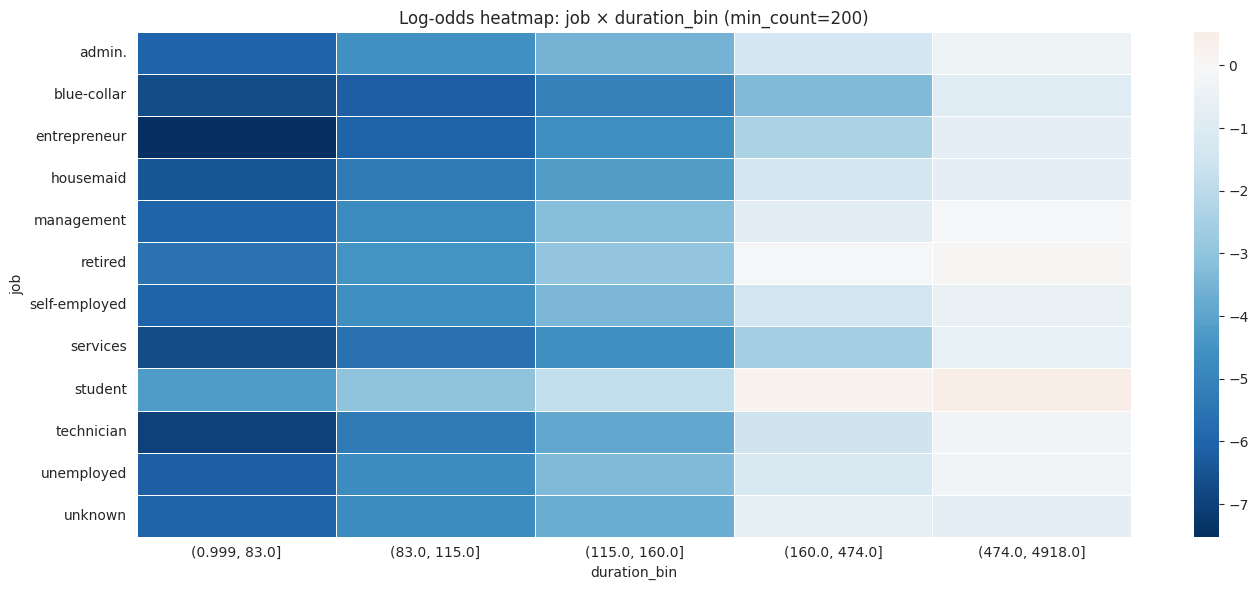

In [22]:
heat7 = interaction_logodds_heatmap(train, 'job', 'duration_bin', target='y', min_count=200)


In [23]:
# 5) Top segments 
segs = top_segments(train, ['job','month','poutcome','contact'], target='y', top_k=20, min_count=100)
display(segs)



,job,month,poutcome,contact,count,positives,rate,uplift
978,student,feb,success,cellular,102,90,0.882353,0.761702
654,retired,jul,success,cellular,147,127,0.863946,0.743295
549,management,mar,success,cellular,245,210,0.857143,0.736492
606,retired,apr,success,cellular,168,142,0.845238,0.724587
1118,technician,jul,success,cellular,154,129,0.837662,0.717012
526,management,jul,success,cellular,252,211,0.837302,0.716651
507,management,feb,success,cellular,519,433,0.834297,0.713646
1055,student,sep,success,cellular,102,85,0.833333,0.712683
718,retired,sep,success,cellular,217,180,0.829493,0.708842
1025,student,may,success,cellular,110,91,0.827273,0.706622


### 🔎 Discovery of top segments

I searched for job × month × poutcome × contact combinations that show both a high conversion rate and sufficient volume (min_count=100). The goal: surface niches with strong uplift versus the baseline (~12%) to prioritize scoring, targeting, or concrete marketing experiments. 🚀

🔥 Analysis — quick takeaways

💥 Overwhelming signal — poutcome = success + contact = cellular
Every top-20 segment shares the same pattern: past success + mobile contact. These two dimensions drive most of the conversion lift.

📈 Extreme rates & massive uplift
Top segments show conversion ~0.78–0.88, i.e. uplifts of +0.66 to +0.76 vs baseline. These are ultra-converting niches — high reward, high priority.

👥 Recurring profiles
Frequently appearing jobs: management, retired, student, technician, blue-collar — different profiles, same strong responsiveness when history is positive and contact is via cellular.


In [24]:
# Logistic regression with poutcome, month, and duration
formula = 'y ~ duration + C(poutcome) + C(month)'
model, or_table = fit_logistic_interaction(train, formula, sample_frac=0.15)  # sample 15%
print(model.summary())
display(or_table.head(20))


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               112500
Model:                          Logit   Df Residuals:                   112484
Method:                           MLE   Df Model:                           15
Date:                Sat, 23 Aug 2025   Pseudo R-squ.:                  0.4047
Time:                        00:14:00   Log-Likelihood:                -24755.
converged:                       True   LL-Null:                       -41587.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.3965      0.058    -58.288      0.000      -3.511      -3.282
C(poutcome)[T.other]       0.0939      0.084      1.117      0.264      -0.071       0.259
C(po

,coef,odds_ratio,ci_lower,ci_upper
C(poutcome)[T.success],3.274192,26.421874,23.039437,30.300890
C(month)[T.mar],2.559035,12.923337,10.911884,15.305573
C(month)[T.oct],1.436514,4.206006,3.584890,4.934737
C(month)[T.sep],1.358240,3.889343,3.257452,4.643810
C(month)[T.dec],1.231995,3.428061,2.548314,4.611520
C(poutcome)[T.other],0.093941,1.098495,0.931518,1.295404
C(month)[T.feb],0.011256,1.011319,0.902279,1.133538
duration,0.005189,1.005203,1.005121,1.005284
C(poutcome)[T.unknown],-0.116070,0.890413,0.812075,0.976308
C(month)[T.aug],-0.438755,0.644839,0.586079,0.709490


### logistic model (duration + poutcome + month)

I fitted a logistic regression on a 15% sample (112,500 rows) to estimate how call duration, previous outcome (poutcome) and month affect the odds of subscription (y). The model converged and shows a decent pseudo-R² (~0.405), so these predictors capture a lot of the signal.

Key findings (interpretation):

poutcome = success → coef ≈ +3.27 → OR ≈ 26.4 🚀
Clients with a previous successful outcome have ~26× larger odds of subscribing vs the baseline group. This is a huge effect (very significant).

Months matter:

Mar (+2.56, OR ≈ 12.9), Oct (+1.44, OR ≈ 4.2), Sep, Dec show strong positive effects (seasonality / campaign timing). 🌟

May, Jul, Jun, Nov, Jan, Aug show large negative coefficients (lower odds). ❄️

Duration: coef ≈ +0.0052 → OR ≈ 1.005 per unit ⏱️
Each additional unit of duration increases the odds of subscription by about 0.5% per unit. If duration is in seconds, a 100-second longer call ≈ exp(0.0052*100) ≈ ~1.70× the odds — so duration is practically important despite a small per-unit coef.

Other levels: poutcome = unknown has a small negative effect; poutcome = other is near zero and not significant.

## outliers

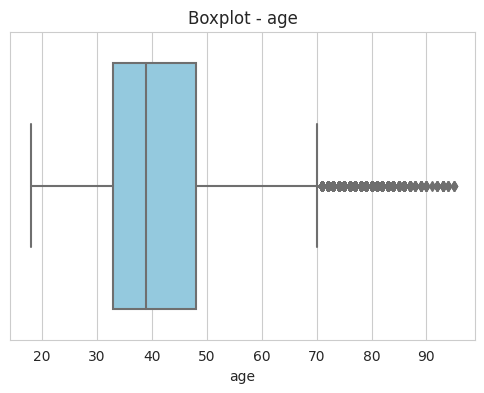

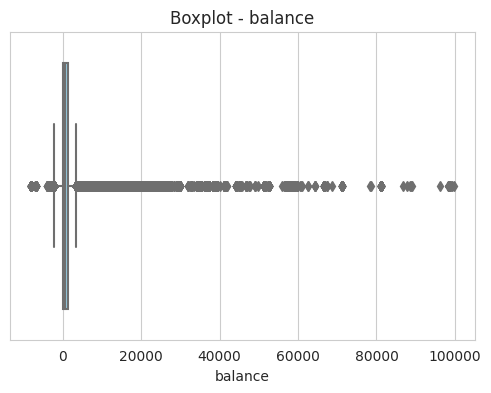

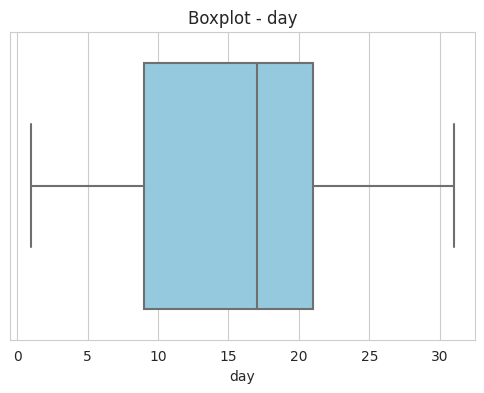

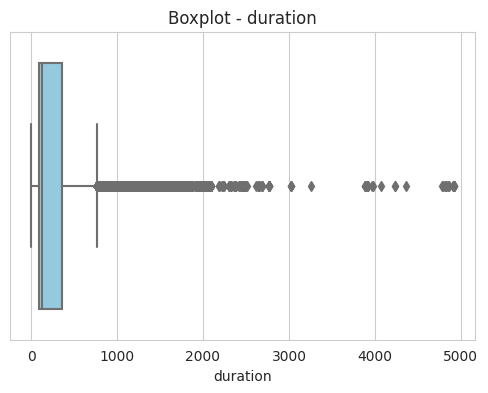

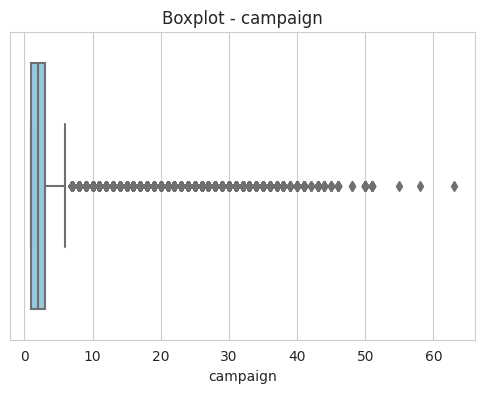

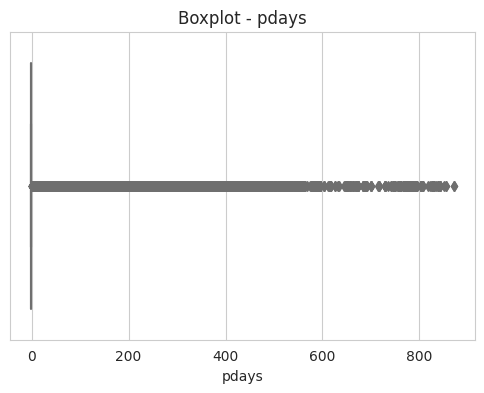

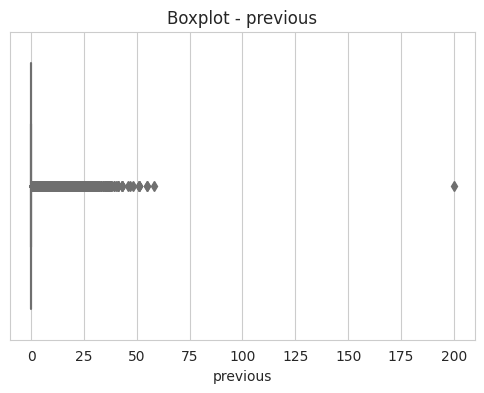

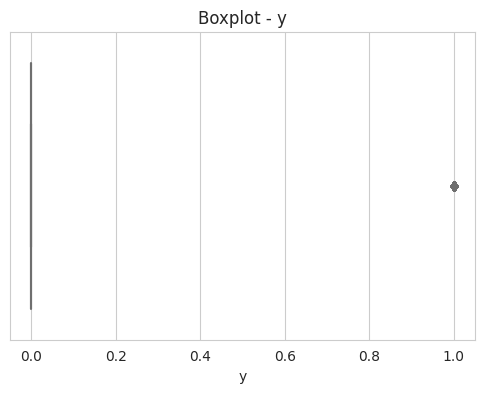

Outlier % per variable: {'age': 0.65, 'balance': 7.7, 'day': 0.0, 'duration': 6.15, 'campaign': 5.42, 'pdays': 10.34, 'previous': 10.34, 'y': 12.07}


In [25]:
def plot_boxplots(df, num_cols):
   
    for col in num_cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=df[col], color="skyblue")
        plt.title(f"Boxplot - {col}")
        plt.show()

def analyze_outliers(df, num_cols):
   
    results = {}
    for col in num_cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        results[col] = round(100 * outliers / len(df), 2)  # %
    return results



numeric_features = train.select_dtypes(include=["int64", "float64"]).columns

# 1. Outlier visualization
plot_boxplots(train, numeric_features)

# 2. Outlier percentage per variable
outlier_summary = analyze_outliers(train, numeric_features)
print("Outlier % per variable:", outlier_summary)


> We observe non-negligible outlier rates on several variables: pdays (~10.3%), previous (~10.3%), balance (~7.7%), duration (~6.15%), campaign (~5.4%). These extremes look like real customer behavior (not data entry errors), so we should not delete them.

> Instead of removing, handle them smartly: use models or transformations that are robust to extremes, add outlier flags so the model can learn from those cases, or apply winsorizing / clipping and sign-preserving transforms (e.g., sign(x)*log1p(|x|) for balances with negatives). Also consider RobustScaler / QuantileTransformer or tree-based models (RandomForest / LightGBM) that tolerate outliers better.

# Feature Engineering to predection

In [26]:
import numpy as np
import pandas as pd

num_cols = ["balance", "duration", "campaign", "previous"] 


def log1p_shift(s):
    min_val = s.min(skipna=True)
    offset = -min_val + 1 if min_val <= 0 else 0
    return np.log1p(s + offset)


train_transformed = train.copy()


for col in num_cols:
    train_transformed[col] = log1p_shift(train_transformed[col])

train_transformed["never_contacted"] = (train_transformed["pdays"] == -1).astype(int)
pdays_pos = train_transformed["pdays"].replace(-1, np.nan)
train_transformed["pdays_log"] = log1p_shift(pdays_pos)

test_transformed = test.copy()

for col in num_cols:
    min_val = train[col].min()
    offset = -min_val + 1 if min_val <= 0 else 0
    test_transformed[col] = np.log1p(test[col] + offset)

test_transformed["never_contacted"] = (test_transformed["pdays"] == -1).astype(int)
pdays_pos_test = test_transformed["pdays"].replace(-1, np.nan)
min_val_pdays = train["pdays"].replace(-1, np.nan).min()
offset_pdays = -min_val_pdays + 1 if min_val_pdays <= 0 else 0
test_transformed["pdays_log"] = np.log1p(pdays_pos_test + offset_pdays)

train_transformed.head()
test_transformed.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,never_contacted,pdays_log
id,,,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,9.150378,yes,no,unknown,21,may,5.416100,0.693147,-1,0.693147,unknown,1,NaN
750001,44,management,married,tertiary,no,8.992682,yes,no,cellular,3,apr,6.375025,1.098612,-1,0.693147,unknown,1,NaN
750002,36,self-employed,married,primary,no,8.995537,yes,yes,cellular,13,may,4.718499,1.098612,-1,0.693147,unknown,1,NaN
750003,58,blue-collar,married,secondary,no,8.801018,yes,yes,unknown,29,may,4.836282,0.693147,-1,0.693147,unknown,1,NaN
750004,28,technician,single,secondary,no,9.207436,yes,no,cellular,22,jul,5.204007,0.693147,-1,0.693147,unknown,1,NaN


In [27]:
test_transformed.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,never_contacted,pdays_log
id,,,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,9.150378,yes,no,unknown,21,may,5.416100,0.693147,-1,0.693147,unknown,1,NaN
750001,44,management,married,tertiary,no,8.992682,yes,no,cellular,3,apr,6.375025,1.098612,-1,0.693147,unknown,1,NaN
750002,36,self-employed,married,primary,no,8.995537,yes,yes,cellular,13,may,4.718499,1.098612,-1,0.693147,unknown,1,NaN
750003,58,blue-collar,married,secondary,no,8.801018,yes,yes,unknown,29,may,4.836282,0.693147,-1,0.693147,unknown,1,NaN
750004,28,technician,single,secondary,no,9.207436,yes,no,cellular,22,jul,5.204007,0.693147,-1,0.693147,unknown,1,NaN


In [28]:
BINARIZE = ["default", "housing", "loan"]
LABEL_COLS = ["marital", "education", "contact", "poutcome", "job"]
MONTH_ORDER = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}

def binarize_columns(train_df, test_df, cols):
    train = train_df.copy()
    test  = test_df.copy()
    created = []
    for c in cols:
        if c in train.columns:
            if train[c].dtype == "O":
               
                mapping = {"yes":1, "y":1, "true":1, "1":1, "no":0, "n":0, "false":0, "0":0}
                train[c + "_bin"] = train[c].astype(str).str.lower().map(mapping).fillna(0).astype(int)
                test[c + "_bin"]  = test[c].astype(str).str.lower().map(mapping).fillna(0).astype(int)
            else:
                
                train[c + "_bin"] = train[c].fillna(0).astype(int)
                test[c + "_bin"]  = test[c].fillna(0).astype(int)
            created.append(c + "_bin")
    return train, test, created

def label_encode_safe(train_df, test_df, cols):
   
    train = train_df.copy()
    test  = test_df.copy()
    mappings = {}
    created = []
    for c in cols:
        if c in train.columns:
            
            tr_vals = train[c].fillna("___NA___").astype(str)
            te_vals = test[c].fillna("___NA___").astype(str)
           
            uniques = pd.Index(tr_vals.unique())
            
            train_cat = pd.Categorical(tr_vals, categories=uniques)
            test_cat  = pd.Categorical(te_vals, categories=uniques)
            train_codes = train_cat.codes.astype(int)   # -1 will not appear for train
            test_codes  = test_cat.codes.astype(int)    # unseen -> -1
            train[c + "_le"] = train_codes
            test[c + "_le"]  = test_codes
            mappings[c] = list(uniques)
            created.append(c + "_le")
    return train, test, mappings, created

def month_cyclic_features(df, month_col="month"):
    out = df.copy()
    if month_col in out.columns:
        mnum = out[month_col].map(MONTH_ORDER).fillna(0).astype(int)
        radians = 2 * np.pi * mnum / 12
        out[month_col + "_sin"] = np.sin(radians)
        out[month_col + "_cos"] = np.cos(radians)
    return out, [month_col + "_sin", month_col + "_cos"] if month_col in out.columns else (out, [])

# ----------------- Apply to your dataframes -----------------
train_tmp = train_transformed.copy()
test_tmp  = test_transformed.copy()

# 1) binarize
train_tmp, test_tmp, bin_cols = binarize_columns(train_tmp, test_tmp, BINARIZE)

# 2) label encode safely
train_tmp, test_tmp, label_mappings, label_cols_created = label_encode_safe(train_tmp, test_tmp, LABEL_COLS)

# 3) month cyclic (adds month_sin, month_cos)
train_tmp, month_cols = month_cyclic_features(train_tmp, "month")
test_tmp, _ = month_cyclic_features(test_tmp, "month")

# 4) package results
train_encoded = train_tmp
test_encoded  = test_tmp
artifacts = {
    "binarized_columns": bin_cols,
    "label_mappings": label_mappings,      # dict col -> list(categories_in_train)
    "label_encoded_columns": label_cols_created,
    "month_cyclic_columns": month_cols
}

# quick info
print("Binarized columns created:", artifacts["binarized_columns"])
print("Label-encoded columns created:", artifacts["label_encoded_columns"])
print("Month cyclic columns:", artifacts["month_cyclic_columns"])
# sample mapping for job (if present)
if "job" in artifacts["label_mappings"]:
    sample_map = {cat:i for i,cat in enumerate(artifacts["label_mappings"]["job"])}
    print("Sample 'job' mapping (train categories -> codes):", dict(list(sample_map.items())[:10]))

train_encoded.head()
test_encoded.head()


Binarized columns created: ['default_bin', 'housing_bin', 'loan_bin']
Label-encoded columns created: ['marital_le', 'education_le', 'contact_le', 'poutcome_le', 'job_le']
Month cyclic columns: ['month_sin', 'month_cos']
Sample 'job' mapping (train categories -> codes): {'technician': 0, 'blue-collar': 1, 'student': 2, 'admin.': 3, 'management': 4, 'entrepreneur': 5, 'self-employed': 6, 'unknown': 7, 'services': 8, 'retired': 9}


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,never_contacted,pdays_log,default_bin,housing_bin,loan_bin,marital_le,education_le,contact_le,poutcome_le,job_le,month_sin,month_cos
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,9.150378,yes,no,unknown,21,may,5.416100,0.693147,-1,0.693147,unknown,1,NaN,0,1,0,0,0,1,0,1,0.500000,-0.866025
750001,44,management,married,tertiary,no,8.992682,yes,no,cellular,3,apr,6.375025,1.098612,-1,0.693147,unknown,1,NaN,0,1,0,0,2,0,0,4,0.866025,-0.500000
750002,36,self-employed,married,primary,no,8.995537,yes,yes,cellular,13,may,4.718499,1.098612,-1,0.693147,unknown,1,NaN,0,1,1,0,1,0,0,6,0.500000,-0.866025
750003,58,blue-collar,married,secondary,no,8.801018,yes,yes,unknown,29,may,4.836282,0.693147,-1,0.693147,unknown,1,NaN,0,1,1,0,0,1,0,1,0.500000,-0.866025
750004,28,technician,single,secondary,no,9.207436,yes,no,cellular,22,jul,5.204007,0.693147,-1,0.693147,unknown,1,NaN,0,1,0,1,0,0,0,0,-0.500000,-0.866025


In [29]:
orig_categorical_cols = ["job", "marital", "education", "contact", "month", "poutcome", "default", "housing", "loan"]
to_drop_train = [c for c in orig_categorical_cols if c in train_encoded.columns]
to_drop_test  = [c for c in orig_categorical_cols if c in test_encoded.columns]

train_encoded = train_encoded.drop(columns=to_drop_train, errors="ignore")
test_encoded  = test_encoded.drop(columns=to_drop_test, errors="ignore")



In [ ]:
train_encoded = train_encoded.drop('duration_bin', axis=1)